In [1]:
import pprint
from collections import defaultdict

import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
import sys
import time
from functools import wraps
try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
    
def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        t_start = time.time()        
        result = func(*args, **kwargs)
        t_end = time.time()
        print ()
        print (func.__name__, '{0:.6f} sec'.format(t_end-t_start))
        return result
    return wrapper

class ProgressBar:
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print ('\r', self, end='')
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

## powerplant

* fuel for warm start: 583.33 MWh ( coal/ gas ratio 0.24 )
* fuel for start: 533.33 + 833.33 MWh ( coal/ gas ratio: 0.31 )
* warm start: standstill <= 8h
* minimum standstill 4h
* minimum running duration 4h
* p_min: 131.2 MW power with 452.22 MW fuel
* p_max: 655.6 MW power with 1743.73 MW fuel
* maximum change 262.2 MW/h
* costs 2.38 EUR/ MWh

* gas costs 55.56 EUR/ MWh and is used for starting. emission is 0.2639 t/ MWh
* CO2 costs in costvector at index 0
* Coal costs in costvector at index 1
* Coal emission is 0.3384 t/ MWh



In [3]:
p_min, p_max = 131, 655
min_fuel, max_fuel = 452.22, 1743.73
gas_emission = 0.2639
coal_emission = 0.3384
fix_cost_per_mw = 2.38
gas_price = 55.56

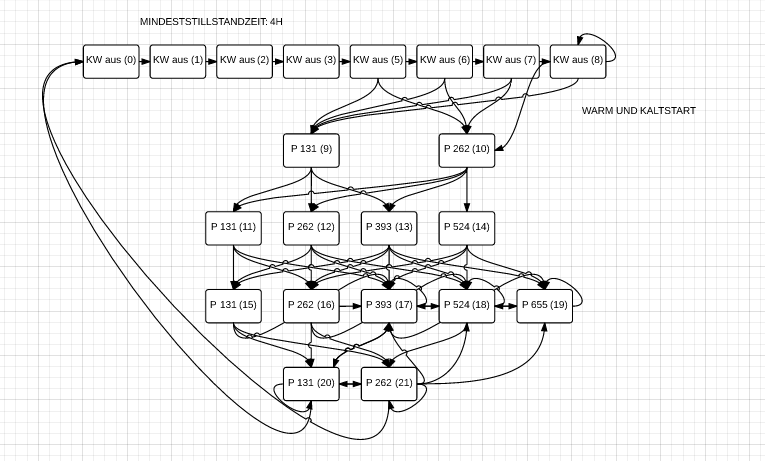

In [4]:
from IPython.display import display, Image
i = Image('./states_powerplant.PNG')
display(i)

In [5]:
states_to = {
    0: [1],
    1: [2],
    2: [3],
    3: [4],
    4: [5, 9, 10], #aus5, warmstart
    5: [6, 9, 10],
    6: [7, 9, 10],
    7: [8, 9, 10],
    8: [8, 9, 10], #aus8, kaltstart
    9: [11, 12, 13],
    10: [11, 12, 13, 14],
    11: [15, 16, 17],
    12: [15, 16, 17, 18],
    13: [15, 16, 17, 18, 19],
    14: [16, 17, 18, 19],
    15: [17, 20, 21],
    16: [17, 18, 20, 21],
    17: [17, 18, 19, 20, 21],
    18: [17, 18, 19, 21],
    19: [17, 18, 19],
    20: [0, 17, 20, 21],
    21: [0, 17, 18, 20, 21],
}
costs_vecs_by_transition = defaultdict(lambda : np.array([0, 0, 0, 0]))
energie_by_transition = defaultdict(lambda : 0.)

In [6]:
#warm start: 533.33 MWh = x + y, x = 0.24y <=> y = 533.33 / 1.24
gas = 533.33 / 1.24
coal = 0.24 * gas
co2 = 0.3884 * coal + 0.2639 * gas
p = 262.2

tuples = [(4, 9), (5, 9), (6, 9), (7, 9)]
#warm start to p/2 
for t in tuples:
    costs_vecs_by_transition[t] = np.array( [co2, coal, -p/4, gas])
    energie_by_transition[t] = p/4

tuples = [(4, 10), (5, 10), (6, 10), (7, 10)]
for t in tuples:
    costs_vecs_by_transition[t] = np.array( [co2, coal, -p/2, gas])
    energie_by_transition[t] = p/2


In [7]:
#start: 583.330 + 833.330
# = x + y, x = 0.31y <=> y = 1416.66 / 1.31
gas = 1416.66 / 1.31
coal = 0.31 * gas
co2 = 0.3884 * coal + 0.2639 * gas
p = 262.2

costs_vecs_by_transition[ (8, 9) ] = np.array( [co2, coal, -p/4, gas])
energie_by_transition[(8, 9)] = p/4

costs_vecs_by_transition[ (8, 10) ] = np.array( [co2, coal, -p/2, gas])
energie_by_transition[(8, 10)] = p/2

In [8]:
p_diff = p_max - p_min
diff = max_fuel - min_fuel
fuel_per_mw = diff / p_diff


In [9]:
def get_fuel_co2(p):
    fuel = min_fuel + (p-p_min) * fuel_per_mw
    co2 = fuel * coal_emission
    return fuel, co2

In [10]:
# transitions with p = 131:
tuples = [
    (9, 11), (11, 15), (15, 20), (20, 20),
]
p = 131
coal, co2 = get_fuel_co2(p)
for t in tuples:
    costs_vecs_by_transition[t] = np.array( [co2, coal, -p, 0] )
    energie_by_transition[t] = p

In [11]:
#131-262, 262-131
p = 393/2
coal, co2 = get_fuel_co2(p)
tuples = [  (9, 11), (11, 16), (15, 21), (20, 21), (10, 11), (12, 15), (16, 20), (21, 20)]
for t in tuples:
    costs_vecs_by_transition[t] = np.array( [co2, coal, -p, 0] )
    energie_by_transition[t] = p

#131->393; 262; 391 -> 131
p = 262
coal, co2 = get_fuel_co2(p)
tuples = [(9, 12), (11, 17), (15, 17), (20, 17), (10, 12), (12, 16),
          (16, 21), (21, 21), (13, 15), (17, 20)]
for t in tuples:
    costs_vecs_by_transition[t] = np.array( [co2, coal, -p, 0] )
    energie_by_transition[t] = p

#262->393, 393-262
p = 655/2
coal, co2 = get_fuel_co2(p)
tuples = [ (10, 13), (12, 17), (16, 17), (21, 17),
          (13, 16), (17, 21)]
for t in tuples:
    costs_vecs_by_transition[t] = np.array( [co2, coal, -p, 0] )
    energie_by_transition[t] = p

#262->524, 393, 524->262
p = 393
coal, co2 = get_fuel_co2(p)
tuples = [
    (10, 14), (12, 18), (16, 18), (21, 18),
    (13, 17), (17, 17),
    (14, 16), (18, 21),
]
for t in tuples:
    costs_vecs_by_transition[t] = np.array( [co2, coal, -p, 0] )
    energie_by_transition[t] = p

#393->524, 524->393
p = (393+524)/2
coal, co2 = get_fuel_co2(p)
tuples = [
    (13, 18), (17, 18),
    (14, 17), (18, 17)
]
for t in tuples:
    costs_vecs_by_transition[t] = np.array( [co2, coal, -p, 0] )
    energie_by_transition[t] = p

#393->655, 524, 655->393
p = 524
coal, co2 = get_fuel_co2(p)
tuples = [
    (13, 19), (17, 19),
    (14, 18), (18, 18),
    (19, 17),
]
for t in tuples:
    costs_vecs_by_transition[t] = np.array( [co2, coal, -p, 0] )
    energie_by_transition[t] = p

#524->655, 655->524
p = (524+655)/2
coal, co2 = get_fuel_co2(p)
tuples = [
    (14, 19), (18, 19),
    (19, 18)
]
for t in tuples:
    costs_vecs_by_transition[t] = np.array( [co2, coal, -p, 0] )
    energie_by_transition[t] = p

#655
p = 655
coal, co2 = get_fuel_co2(p)
costs_vecs_by_transition[(19, 19)] = np.array( [co2, coal, -p, 0] )
energie_by_transition[(19, 19)] = p

In [12]:
def opti(timesteps, nbr_states, cost_matrix):
    way = np.zeros( (timesteps, nbr_states) )
    cur_costs = np.zeros( nbr_states )
    last_costs = np.zeros( nbr_states )

    for t in reversed(range(timesteps)):
        last_costs = cur_costs.copy()
        for cur_state, to_states in states_to.items():
            min_tuple = min((np.dot(cost_matrix[t], costs_vecs_by_transition[(cur_state, to_state)]) \
                + last_costs[to_state], to_state) for to_state in to_states)
            #update cost array with min costs
            cur_costs[cur_state] = min_tuple[0]
            way[t][cur_state] = min_tuple[1]
    return cur_costs, way

In [13]:
def read_cost_matrix(i):
    '''
    reads matrix with co2, coal and powerprice and adds a constant column
    with gas prices
    
    reads the i-th simulation
    '''
    data_matrix = np.load('./arr_{:04d}.npy'.format(i))
    steps, _ = data_matrix.shape
    cost_matrix = np.hstack( (data_matrix, gas_price * np.ones((steps, 1))))
    cost_matrix[:,2] = cost_matrix[:,2] - fix_cost_per_mw
    return cost_matrix


In [14]:
@timeit
def calc_simus(nbr_of_simus, timesteps, nbr_states):
    pb = ProgressBar(nbr_of_simus)
    vals = []
    for i in range(nbr_of_simus):
        pb.animate(i+1)
        cost_matrix = read_cost_matrix(i)
        cur_costs, way = opti(timesteps, nbr_states, cost_matrix)
        vals.append(min(cur_costs))
    return vals

In [15]:
nbr_states = len(states_to)
timesteps = 8760

In [16]:
optimal_values = calc_simus(20, timesteps, nbr_states)

 [****************100%******************]  20 of 20 complete
calc_simus 21.321685 sec


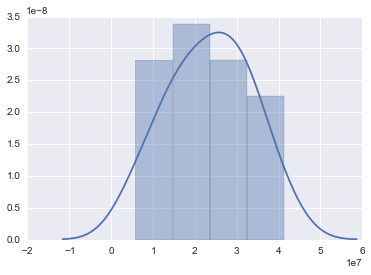

In [17]:
value_series = pd.Series(optimal_values)
sns.distplot(-value_series)